# CANOPy Occlusion Mapping Tutorial

Welcome to the CANOPy Occlusion Mapping tutorial! This notebook will guide you through the process of performing occlusion mapping using solely a point cloud and the tools provided in the CANOPy toolbox. Improvements implemented towards [Gassilloud et al. (2025)](https://www.sciencedirect.com/science/article/pii/S1569843225001402) are noted [here](README.md#changelog). Licensed under the [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/).


## What is Occlusion?

Occlusion in forest LiDAR scans describes space that could not be sampled due to the blocking of light by vegetational elements. Occlusion appears when all the light energy of the emitted laser beam has been backscattered or absorbed through objects so that no additional information can be obtained from further reflections. Mapping occlusion is crucial for accurate forest structure characterization to identify areas where LiDAR data is incomplete or obscured, enabling better interpretation of morphological metrics and improving estimates of biomass and carbon storage.


## Tutorial Overview

This tutorial is divided into three steps:

1. **[Sensor Position Reconstruction](#step-1-sensor-position-reconstruction)**: Reconstructing LiDAR sensor position data from a point cloud.
2. **[Pulse Origin Reconstruction](#step-2-sensor-position-reconstruction)**: Reconstructing the pulse origin of laser pulses and beam trajectories using the reconstructed sensor position.
3. **[Occlusion Mapping](#step-3-occlusion-mapping)**: Perform occlusion mapping with the reconstructed rays.


**Installation**

Follow the installation instructions [here](../README.md#installation).

**Example Data**

In this tutorial, we will use example data and configuration parameters provided in `./example`. Download example data [here](https://www.bwsyncandshare.kit.edu/s/nS9xAFG6qBdqf7T) and move to `./example/data` or adapt the corresponding file paths in the [example config files](./example).

<br>

**Let's get started!**




<br>

### Step 1: Sensor Position Reconstruction

Occlusion mapping traces LiDAR beams through space, wherefore their trajectory and pulse origin need to be reconstructed. Sometimes, the position data of airborne vehicles is not provided or does not represent sensor position well enough (e.g. when the sensor is mounted on a moving gimbal). In this case, LiDAR sensor position data can be reconstructed from the point cloud. In LiDAR scanning, the sensor emits laser pulses and records the returns. By reconstrucing pulse trajectories with multiple returns and extending the trajectory backwards, we can estimate the sensor's position. We have the parameters already defined in our [example config file](./example/example_config_sensor_position_reconstruction.yml).

The main steps are:

1. Reconstruct trajectories with multiple returns
2. Calculate closest points between consecutive trajectories
3. Create time intervals, calculate median of closest points -> this is our sensor position
4. Assign gps_time of closest trajectory to sensor position

Returns: sensor_position_reconstruction.gpkg


<br>

**Option 1: Command Line**

To run sensor position reconstruction from the command line:

```bash
python path/to/sensor_position_reconstruction.py --config path/to/example_config_sensor_position_reconstruction.yml
```


**Option 2: Python**

Now, let's reconstruct sensor positions using the python modules. We'll use directly the function `reconstruct_uav_sensor_trajectory` but feel free to take a closer look at the available functions.

Read point cloud.
    read all points.
    read dimensions: ['gps_time', 'x', 'y', 'z', 'return_number']
    metadata: {'Points Read': 10488086, 'Total point_count': 10488086, 'gps_encoding_value': 0, 'gps_time_type': <GpsTimeType.WEEK_TIME: 0>, 'dimensions': ['gps_time', 'x', 'y', 'z', 'return_number'], 'las_header': <LasHeader(1.2, <PointFormat(3, 0 bytes of extra dims)>)>}
Sort point cloud, count unique values
Extend pulses with multiple returns
Reconstruct sensor position from closest points
Reconstructed 3175 positions
Assign gps_time of closest trajectories to reconstructed sensor positions.
Average number of trajectories for each reconstructed sensor position: 696.3914960629921
Average distance between closest trajectory and sensor position: 0.00024610108293013344


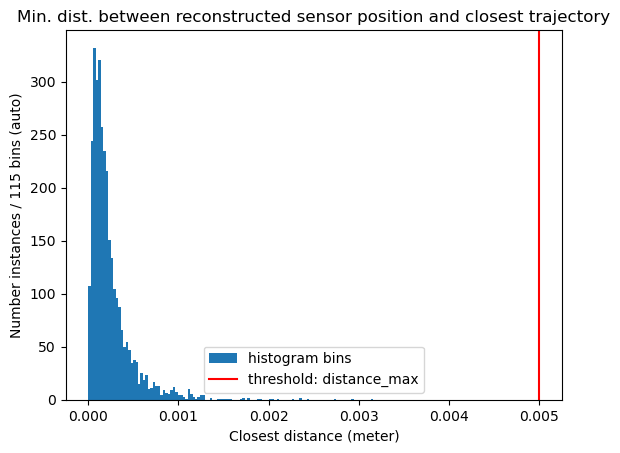

Assigned gps_time to 3175 positions
Extrapolate to start position.
Extrapolate to last position.
Store file.
Sensor reconstruction complete.


In [1]:
import sys
import os
from pathlib import Path

current_dir = Path(os.getcwd()).parent.parent
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))

from CANOPy.occlusion_mapping.configs.config import create_sensor_position_reconstruction_config
from CANOPy.occlusion_mapping.sensor_position_reconstruction import reconstruct_uav_sensor_trajectory

# create config
config_path = Path("./example/example_config_sensor_position_reconstruction.yml")  # path to example config file
cfg = create_sensor_position_reconstruction_config(config_path)  # create config

# read parameters
point_cloud_path = cfg["point_cloud_path"]
epsg = cfg["epsg_code"]
sensor_position_path = cfg["position_reconstruction"]
extension_max = cfg["sensor_position_reconstruction_kwargs"]["extension_max"]
positions_per_second = cfg["sensor_position_reconstruction_kwargs"]["positions_per_second"]
traj_number_min = cfg["sensor_position_reconstruction_kwargs"]["traj_number_min"]
distance_max = cfg["sensor_position_reconstruction_kwargs"]["distance_max"]
extrapolate = cfg["sensor_position_reconstruction_kwargs"]["extrapolate"]

# run trajectory reconstruction
reconstruct_uav_sensor_trajectory(point_cloud_path=point_cloud_path,
                                  sensor_position_path=sensor_position_path,
                                  epsg=epsg,
                                  extension_max=extension_max,
                                  positions_per_second=positions_per_second,
                                  traj_number_min=traj_number_min,
                                  distance_max=distance_max,
                                  extrapolate=extrapolate)

In result, 3175 sensor positions could be reconstructed. We can see that the distances between a reconstructed sensor position and their closest reconstructed LiDAR beam trajectroy from multiple returns are smaller the `distance_max` value set in our config file. Therefore, we were able to assign `gps_time` from the closest beam trajectory to all our sensor positions. The resulting sensor positions are exported as a .gpkg file. Lets have a look at the results:

![Reconstructed sensor positions.](./example/sensor_position_reconstruction/sensor_position_example1.png "Reconstructed sensor positions.")

We can see that the reconstructed sensor positions represent the movement trajectroy of our LiDAR sensor. Lets take a closer look:

![Reconstructed sensor positions, close.](./example/sensor_position_reconstruction/sensor_position_example2.png "Reconstructed sensor positions, close.")




<br><br>

### Step 2: Sensor Position Reconstruction

Now that we have reconstructed the sensor positions, we can reconstruct the individual LiDAR beam trajectories. We have the parameters already defined in our [example config file](./example/example_config_pulse_origin_recosntruction.yml).


The main steps are:
1. The last return of each pulse is taken as the end of the LiDAR beam trajectory.
2. The pusle origin is reconstructed:
    * beams with single returns: the pulse origin is estimated with a linear interpolation between the previous and following sensor position
    * beams with multiple returns: the pulse origin is estimated by extending the trajectory to the height of the previous sensor position

Returns: rays.npy (start_coordinate, end_coordinate, gps_time)

Note: Beams with `gps_time` outside the range of sensor positions get excluded.


<br>

**Option 1: Command Line**

To run pulse origin reconstruction from the command line:

```bash
python path/to/pulse_origin_reconstruction.py --config path/to/example_config_pulse_origin_reconstruction.yaml
```


**Option 2: Python**

In [2]:
import sys
import os
from pathlib import Path
import numpy as np

current_dir = Path(os.getcwd()).parent.parent
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))
    
from CANOPy.occlusion_mapping.configs.config import create_pulse_origin_reconstruction_config
from CANOPy.occlusion_mapping.pulse_origin_reconstruction import reconstruct_pulse_origin


cfg = create_pulse_origin_reconstruction_config("./example/example_config_pulse_origin_reconstruction.yml")

point_cloud_path = cfg["point_cloud_path"]
sensor_position_path = cfg["sensor_position_path"]
rays_storage_path = cfg['rays_path']


The `start_coordinate`, `end_coordinate` and `gps_time` get stored as a .npy array in `rays_storage_path` or can be returned and used directly. Feel free to take a closer look at the module.

In [3]:

start_coordinate, end_coordinate, gps_time = reconstruct_pulse_origin(point_cloud_path=point_cloud_path,
                                        sensor_position_path=sensor_position_path,
                                        rays_storage_path=rays_storage_path)

print("Start coordinate: ", start_coordinate)
print("End coordinate: ", end_coordinate)
print("GPS time: ", gps_time)

# read stored values 
with open(cfg["rays_path"], 'rb') as f:
    start_coordinate = np.load(f)
    end_coordinate = np.load(f)
    gps_time = np.load(f)
    print("Start coordinate: ", start_coordinate)
    print("End coordinate: ", end_coordinate)
    print("GPS time: ", gps_time)


Read point cloud.
    read all points.
    read dimensions: ['gps_time', 'x', 'y', 'z', 'return_number']
    metadata: {'Points Read': 10488086, 'Total point_count': 10488086, 'gps_encoding_value': 0, 'gps_time_type': <GpsTimeType.WEEK_TIME: 0>, 'dimensions': ['gps_time', 'x', 'y', 'z', 'return_number'], 'las_header': <LasHeader(1.2, <PointFormat(3, 0 bytes of extra dims)>)>}
Read sensor positions.
Sort point cloud, count unique values.
Reconstruct pulses with multiple returns.
Reconstruct pulse origin for single returns.
Calculate theoretical start point.
Excluded pulses: 0 / 5378074         -> 0.0%
Stack results.
Store results.
Pulse origin reconstruction complete.
Start coordinate:  [[4.16720994e+05 5.34675953e+06 5.78627303e+02]
 [4.16720994e+05 5.34675953e+06 5.78627304e+02]
 [4.16720994e+05 5.34675953e+06 5.78627305e+02]
 ...
 [4.16717912e+05 5.34675341e+06 5.78908074e+02]
 [4.16717912e+05 5.34675341e+06 5.78908074e+02]
 [4.16717912e+05 5.34675341e+06 5.78908074e+02]]
End coordin

<br>

### Step 3: Occlusion Mapping

Now that we have reconstructed LiDAR beam trajectories, we can map occlusion. For our example, we have already defined some parameters in our [example config file](./example/example_config_occlusion_mapping.yml). Take a look to explore what parameters can be chosen.


The main steps are:
1. Voxel-based raytracing
   * Divison of space into a 3D voxel grid with `cell_size`
   * Ray tracing of LiDAR beam trajectories through voxel space
   * Classification of voxels into four categories: unobserved, occluded, empty, and filled
2. Masking result with area of interest [ optional ]
3. Height normalization with digital terrain model [ optional ]


<br>

**Option 1: Command Line**

To run pulse origin reconstruction from the command line:

```bash
python path/to/occlusion_mapping.py --config path/to/example_config_occlusion_mapping.yaml
```


**Option 2: Python**


In [4]:
import sys
import os
from pathlib import Path
import numpy as np
import numpy.ma as ma
import json

current_dir = Path(os.getcwd()).parent.parent
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))
    
from CANOPy.occlusion_mapping.configs.config import create_occlusion_mapping_config
from CANOPy.occlusion_mapping.occlusion_mapping import occlusion_classification
from CANOPy.geos_utils.geodata_tb.raster_tb import read_raster_array, crop_raster, write_raster_array, transform_affine_from_origin
from CANOPy.occlusion_mapping.occlusion_mapping import plot_example


cfg = create_occlusion_mapping_config("./example/example_config_occlusion_mapping.yml")
metadata = {}


### read cfg parameters
cell_size = cfg["voxel_traversal_kwargs"]["params"]["cell_size"]
xyz_bounds = cfg["voxel_traversal_kwargs"]["params"]["boundary"]
nb_cell = cfg["voxel_traversal_kwargs"]["params"]["nb_cell"]
print(f"XYZ Boundaries: {xyz_bounds}, Number of cells: {nb_cell}")  # status


### occlusion classification
vox_ray_class, xyz_bounds = occlusion_classification(cfg)

Polygon boundary size: [40. 30.]
Get XYZ range for  .\example\data\2024_08_22_MID904_sel.laz
XYZ Boundaries: [[4.1673030e+05 5.3467402e+06 5.1290000e+02]
 [4.1677020e+05 5.3467701e+06 5.6920000e+02]], Number of cells: [399 299 563]
Filter points within .\example\data\filter_turns.shp
    {'Original number of points': 7589119, 'Remaining points': 5475393, 'Removed points': 2113726}
Numba compilation of voxel traversal algorithm, test run...
    Elapsed time (with compilation): 0.003 min
Voxel traversal of rays observed...
    Elapsed time (without compilation): 0.0134 min
Voxel traversal of rays occluded...
    Elapsed time (without compilation): 0.0156 min
Voxelize point cloud...
    read all points.
    read dimensions: ['x', 'y', 'z']
    metadata: {'Points Read': 10488086, 'Total point_count': 10488086, 'gps_encoding_value': 0, 'gps_time_type': <GpsTimeType.WEEK_TIME: 0>, 'dimensions': ['x', 'y', 'z'], 'las_header': <LasHeader(1.2, <PointFormat(3, 0 bytes of extra dims)>)>}
    Elap

Mask result with area of interest. [ optional ]

In [5]:
use_aoi_mask = cfg["aoi"] and cfg["aoi_kwargs"]["aoi_polygon"]["mask"]

### create aoi mask
if use_aoi_mask:  # mask dtm with polygon

    # initialize bool raster
    mask_aoi_array = np.full((nb_cell[1],nb_cell[0]), 1, dtype = np.byte)  # create mask array, initialize True
    mask_aoi_transform = transform_affine_from_origin(xyz_bounds[0][0], xyz_bounds[1][1], cell_size, cell_size)  # create transform
    write_raster_array(cfg["aoi_kwargs"]["array_mask"], mask_aoi_array, cfg["epsg_code"], mask_aoi_transform)  # store as raster

    # mask bool raster with "0" outside polygon
    crop_raster(raster_in= cfg["aoi_kwargs"]["array_mask"],
                    raster_out= cfg["aoi_kwargs"]["array_mask"],  # overwrite
                    crop_shp= cfg["aoi_kwargs"]["aoi_polygon"]["aoi_path"],  # shapefiel to mask raster
                    crop= False)  # mask raster with "0" instead of cropping

    # read bool raster, "0" = masked 
    aoi_mask, aoi_mask_meta = read_raster_array(cfg["aoi_kwargs"]["array_mask"])  # read aoi mask
    aoi_mask = ~aoi_mask.astype(bool)  # now "True = masked"

    # mask
    vox_ray_class = ma.masked_array(vox_ray_class, mask=np.broadcast_to(aoi_mask, vox_ray_class.shape))  # A broadcast usually does not involve copying the data n-time. It just simulates it by setting a stride appropriately.


Store result.

In [6]:
### store result
np.savez(cfg['voxel_result'], vox_ray_class)

metadata["xyz_bounds"] = xyz_bounds.tolist()
metadata["cell_size"] = cell_size

with open(cfg['metadata_result'], 'w') as fp:
    json.dump(metadata, fp, sort_keys=True, indent=4)

Lets have look at our result which are not height normalized:

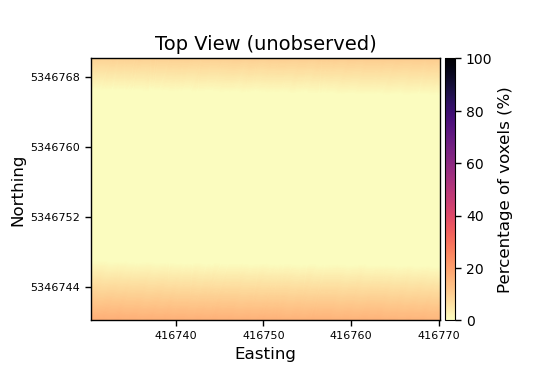

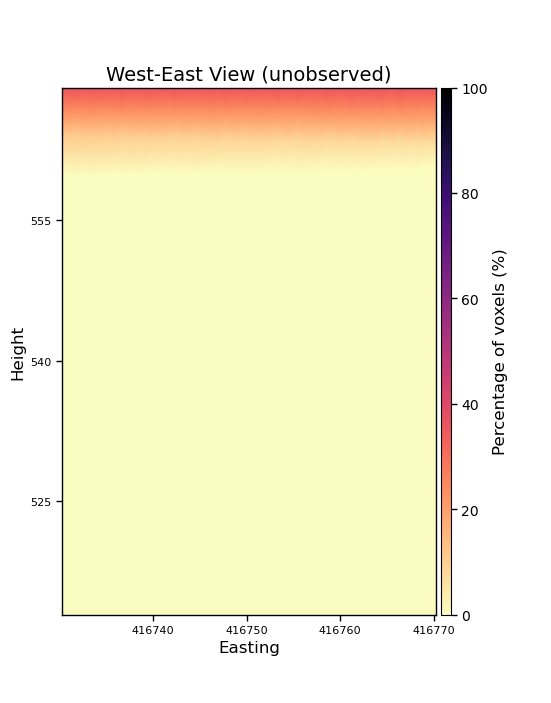

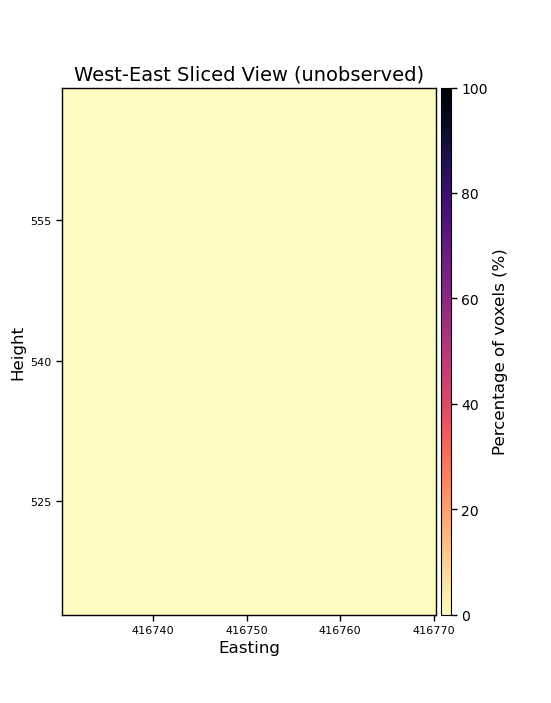

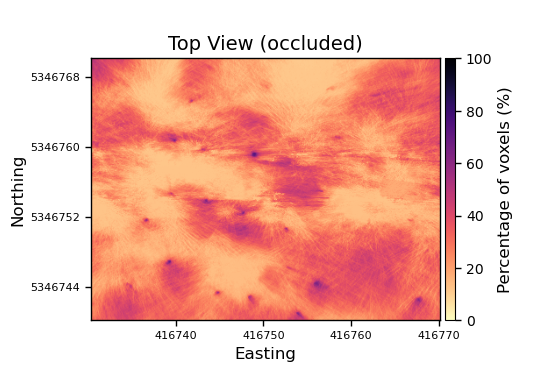

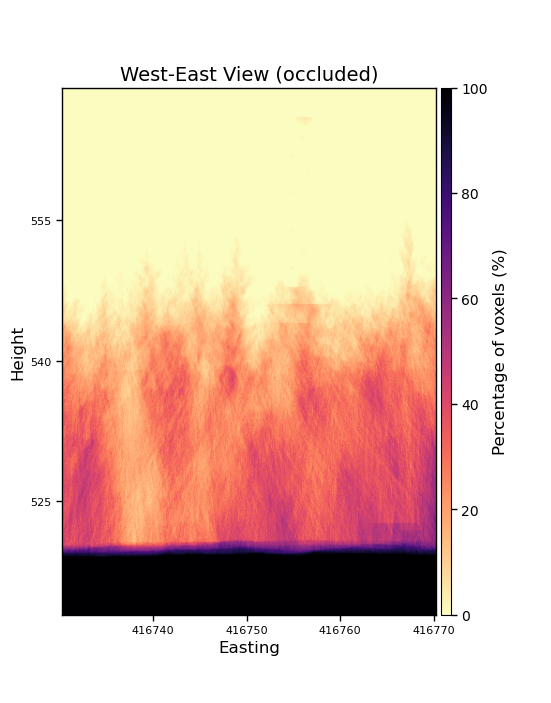

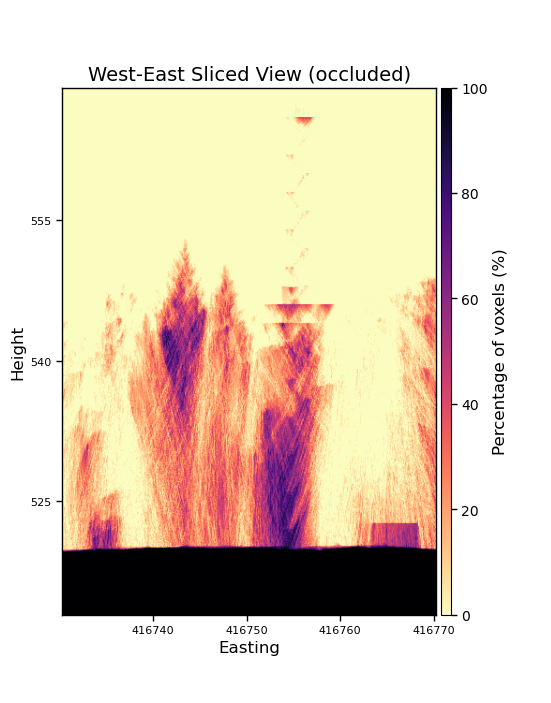

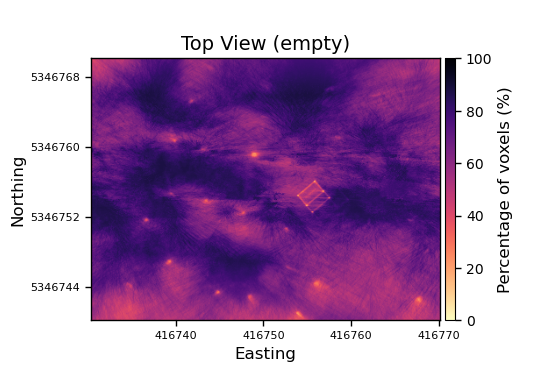

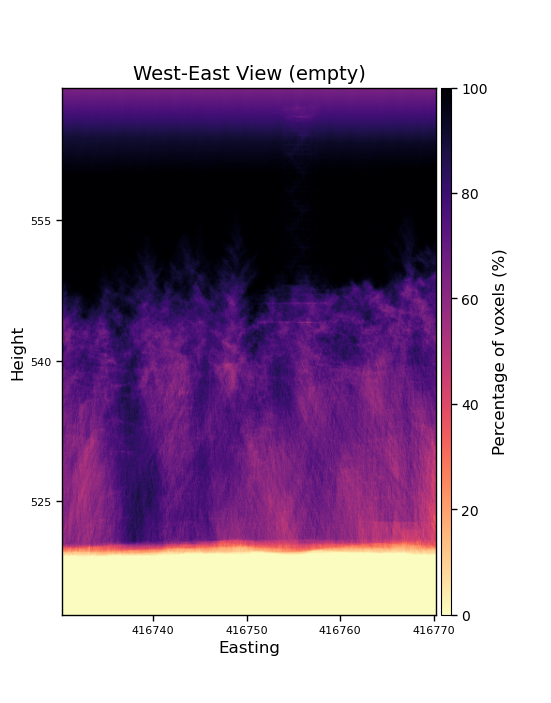

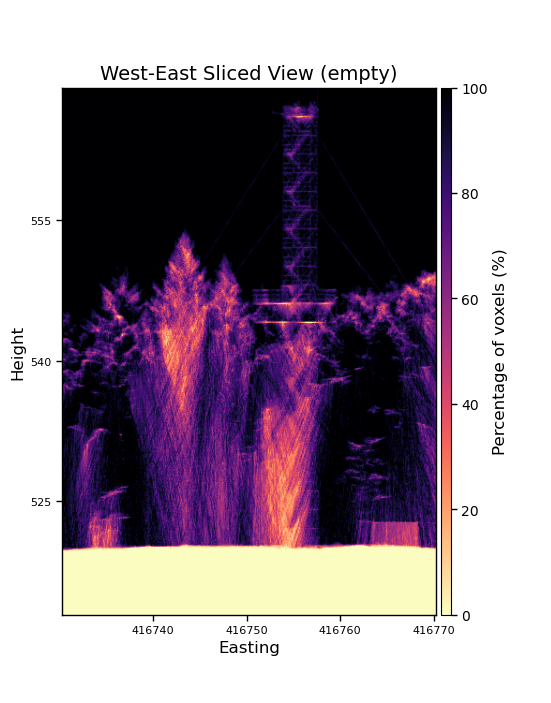

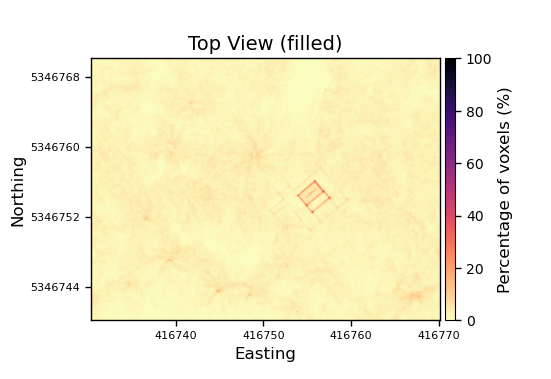

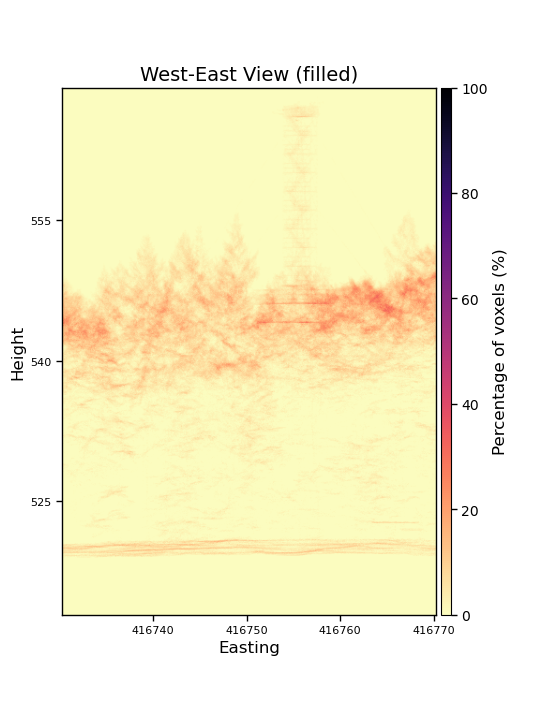

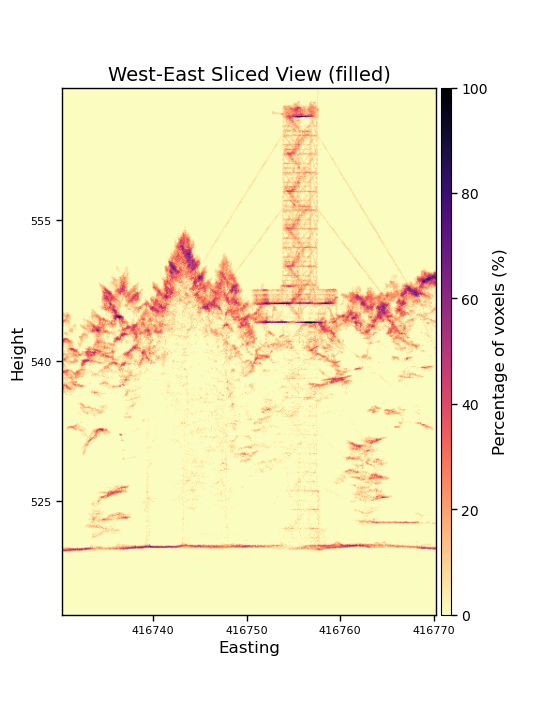

In [7]:
### plot example
plot_example(vox_array=vox_ray_class, xyz_bounds=xyz_bounds, cfg=cfg, classification="unobserved", write=True)
plot_example(vox_array=vox_ray_class, xyz_bounds=xyz_bounds, cfg=cfg, classification="occluded", write=True)
plot_example(vox_array=vox_ray_class, xyz_bounds=xyz_bounds, cfg=cfg, classification="empty", write=True)
plot_example(vox_array=vox_ray_class, xyz_bounds=xyz_bounds, cfg=cfg, classification="filled", write=True)


Height normalization with digital terrain model. [ optional ]

In [8]:
from osgeo import gdal
from CANOPy.geos_utils.geodata_tb.point_cloud_tb import normalize_vox_array


normalize_height = cfg["normalize_height"]


### match DTM to regular voxel grid for height normalization
if normalize_height:

    # reproject/ match voxel grid / crop to xyz bounds, documentation: https://gdal.org/en/stable/api/python/utilities.html
    ds = gdal.Warp(cfg["normalize_height_kwargs"]['dtm_tmp_path'],
                cfg["normalize_height_kwargs"]["dtm_path"],
                outputBounds= (xyz_bounds[0,0], xyz_bounds[0,1], xyz_bounds[1,0], xyz_bounds[1,1]),  # (minX, minY, maxX, maxY) in target SRS
                xRes= cell_size,  # cell_size
                yRes= cell_size,  # cell_size
                width= nb_cell[0],  # cols
                height= nb_cell[1],  # rows
                dstSRS= f"EPSG:{cfg['epsg_code']}",  # srs
                resampleAlg= "nearest"  # can be adapted to the users needs: resampleAlg = nearest|bilinear|cubic|cubicspline|lanczos|average|rms|mode|min|max|med|q1|q3|sum (default: nearest)
                )
    ds = None  # close

    # read dtm
    dtm, dtm_meta = read_raster_array(cfg["normalize_height_kwargs"]['dtm_tmp_path'])  # read aoi mask
    dtm_nodata = dtm_meta['nodata']  # raster no data value            


    ### if aoi polygon mask check only for no data values within aoi
    if use_aoi_mask:  # mask dtm with polygon
    
        # check if no data value are within aoi
        dtm_missing_aoi = (dtm == dtm_nodata) & ~aoi_mask  # (True where no data AND True where within AOI)

        if np.any(dtm_missing_aoi):  # True if at least one True
                        
            print(f"Existing DTM no data value: {dtm_meta['nodata']}, assert this aligns with DTM values.")
    
            raise ValueError(f"Missing {np.sum(dtm_missing_aoi)} DTM grid cell values within AOI. " \
            "Values necessary for height normalization.\n" \
            "  1) Assert AOI Polygon is covered by DTM.\n" \
            "  2) Check if DTM has missing values within Polygon.\n" \
            "  -> You could try an interpolation to fill missing DTM values.")

        else:  # mask array outside aoi polygon with np.nan

            dtm[dtm == dtm_nodata] = np.nan  # set to np.nan
            dtm[aoi_mask] = np.nan  # set values outside aoi to np.nan


    else: # no masking (dtm already matched to voxel grid dimensions), still check if no data in xyz bounds
        
        # check if no data value are within xyz bounds
        dtm_missing_xyz_bounds = (dtm == dtm_nodata)  # True where no data 
        
        if np.any(dtm_missing_xyz_bounds):  # True if at least one True

            print(f"Existing DTM no data value: {dtm_meta['nodata']}, assert this aligns with DTM values.")
    
            raise ValueError(f"Missing {np.sum(dtm_missing_xyz_bounds)} DTM grid cell values in xyz bounds. " \
            "Values necessary for height normalization.\n" \
            "  1) Assert xyz bounds are covered by DTM.\n" \
            "  2) Check if DTM has missing values within xyz bounds.\n" \
            "  -> You could try an interpolation to fill missing DTM values.")


    ### normalize height
    vox_ray_class_norm, xyz_bounds_norm = normalize_vox_array(vox_ray_class, dtm, xyz_bounds, cell_size)


    ### if aoi polygon mask check only for no data values within aoi
    if use_aoi_mask:  # mask dtm with polygon
        vox_ray_class_norm = ma.masked_array(vox_ray_class_norm, mask=np.broadcast_to(aoi_mask, vox_ray_class_norm.shape))

c:\Users\MG\.local\share\mamba\envs\canopy\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
c:\Users\MG\.local\share\mamba\envs\canopy\lib\site-packages\numpy\_core\numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Store result with normalized height.

In [9]:
### store
np.savez(cfg['voxel_result_normalized_height'], vox_ray_class_norm)

metadata["xyz_bounds_norm"] = xyz_bounds_norm.tolist()

with open(cfg['metadata_result'], 'w') as fp:
    json.dump(metadata, fp, sort_keys=True, indent=4)

Lets have look at our result which are now height normalized:

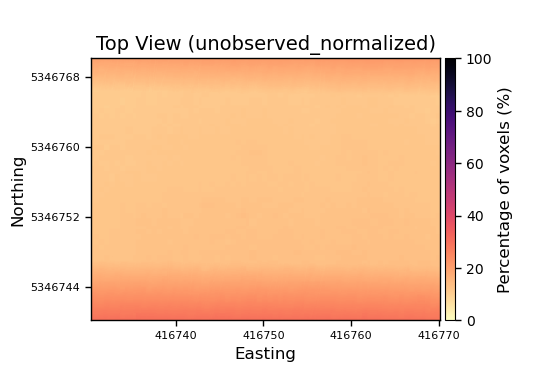

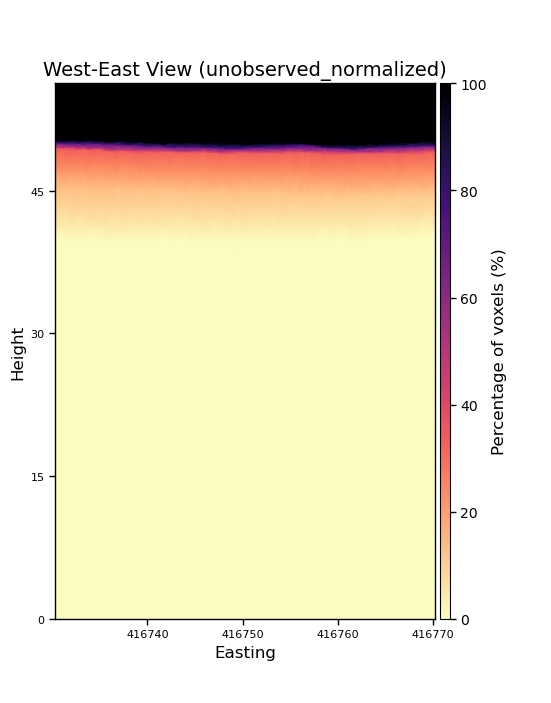

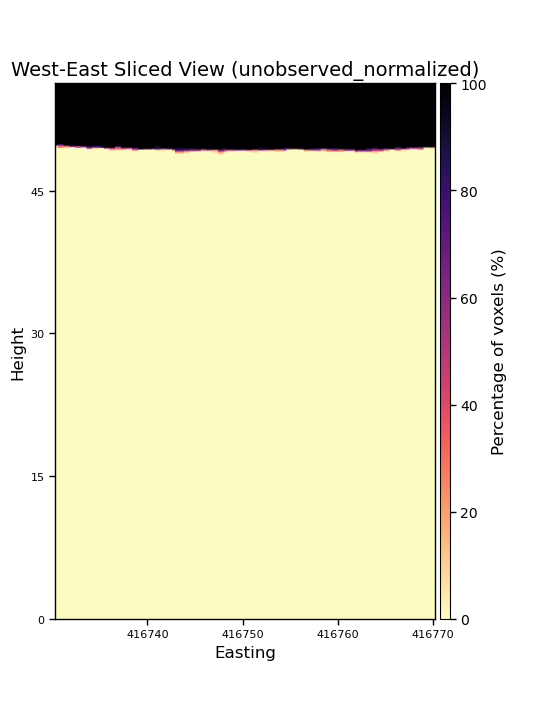

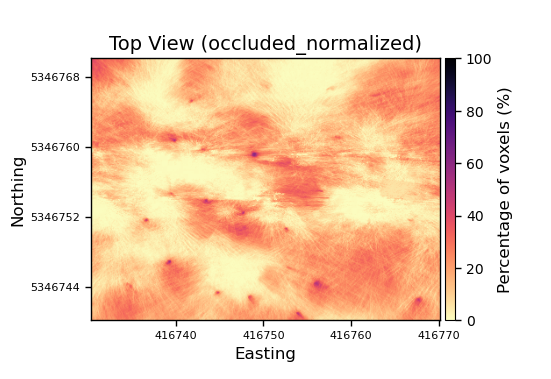

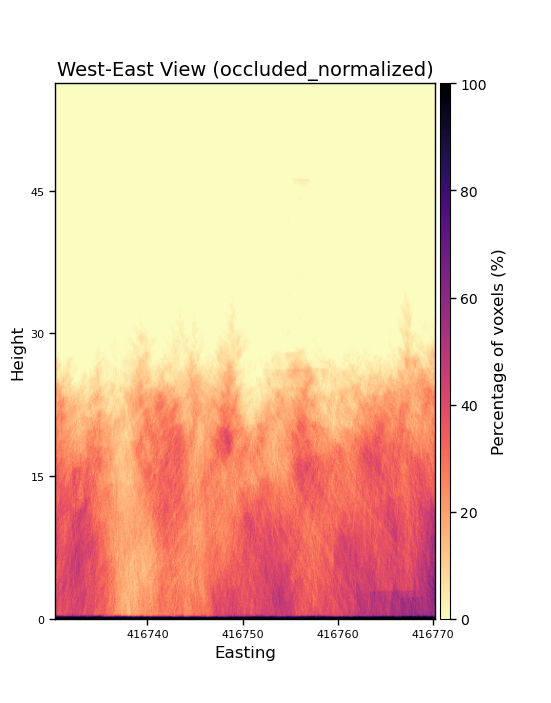

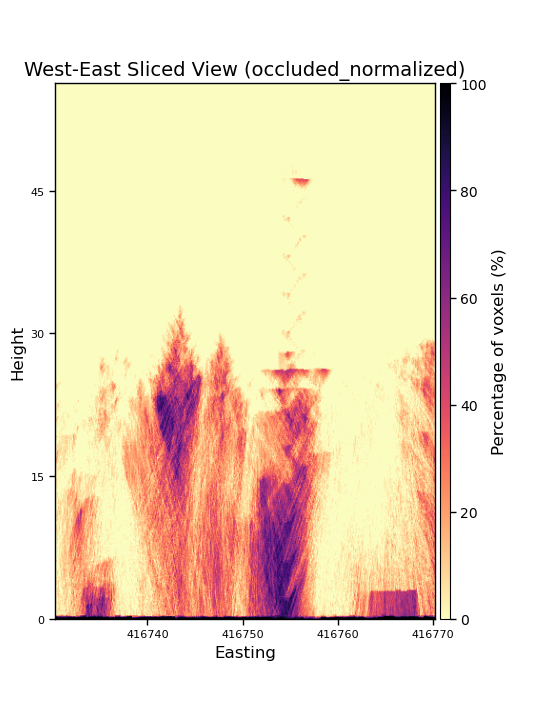

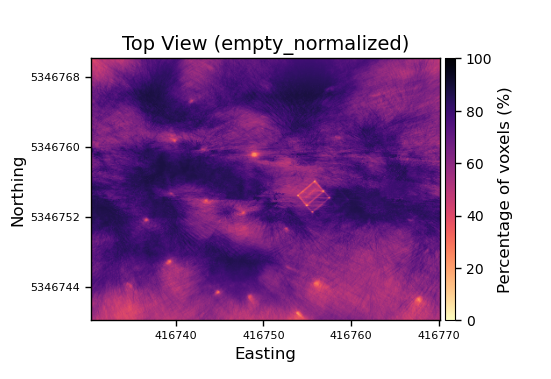

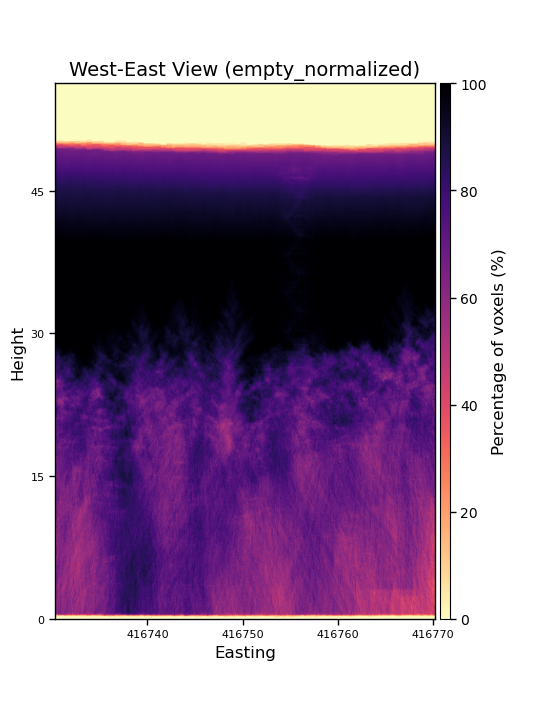

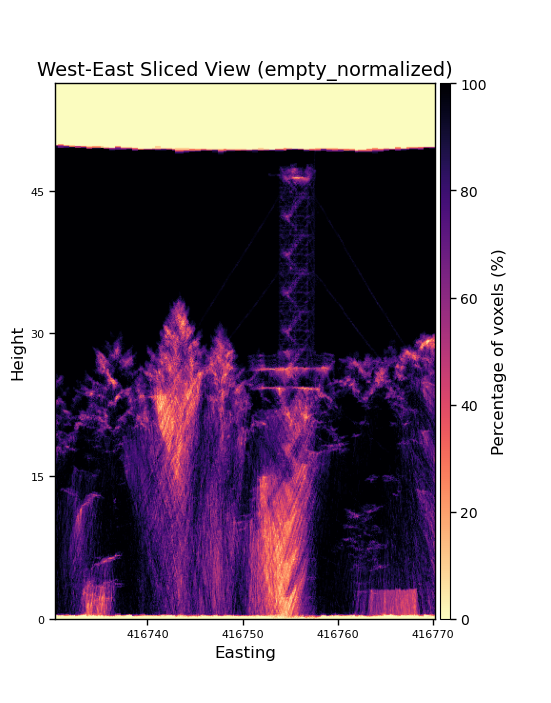

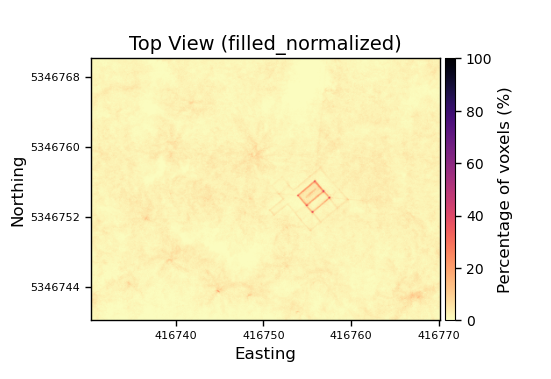

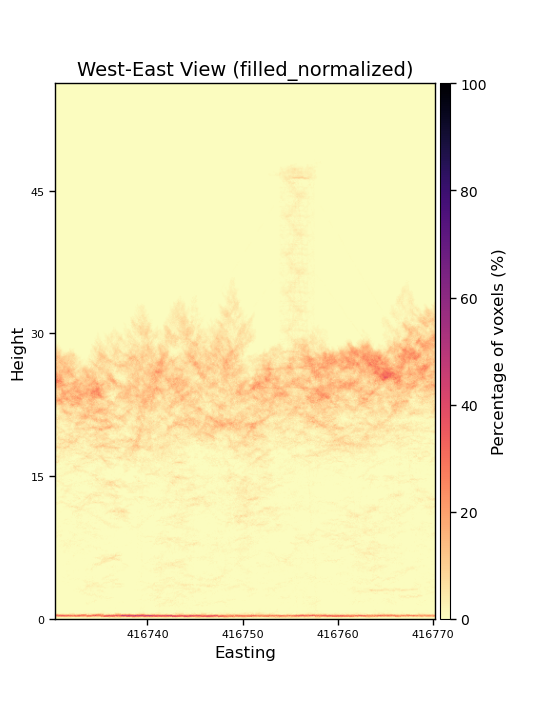

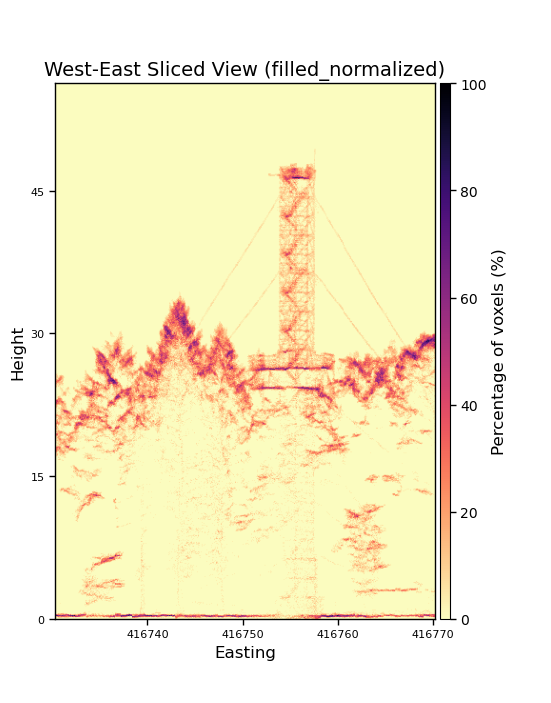

In [10]:
### plot example
plot_example(vox_array=vox_ray_class_norm, xyz_bounds=xyz_bounds_norm, cfg=cfg, classification="unobserved", normalized=True, write=True)
plot_example(vox_array=vox_ray_class_norm, xyz_bounds=xyz_bounds_norm, cfg=cfg, classification="occluded", normalized=True, write=True)
plot_example(vox_array=vox_ray_class_norm, xyz_bounds=xyz_bounds_norm, cfg=cfg, classification="empty", normalized=True, write=True)
plot_example(vox_array=vox_ray_class_norm, xyz_bounds=xyz_bounds_norm, cfg=cfg, classification="filled", normalized=True, write=True)

## Conclusion

This tutorial demonstrates the three key steps of CANOPy's occlusion mapping workflow:

1. **Sensor Position Reconstruction** - Reconstructing sensor position from a point cloud.
2. **Pulse Origin Reconstruction** - Construction of LiDAR beams from pusle origin to last return
3. **Occlusion Mapping** - Voxel-based ray tracing and classification of occluded space.

For more information, consider the [occlusion mapping README.md](./README.md) and [CANOPy README.md](../README.md) and for a detailled explanation have a look at [Gassilloud, M., Koch, B., & Goeritz, A. (2025)](https://www.sciencedirect.com/science/article/pii/S1569843225001402).

## References

[Gassilloud, M., Koch, B., & Goeritz, A. (2025)](https://www.sciencedirect.com/science/article/pii/S1569843225001402). Occlusion mapping reveals the impact of flight and sensing parameters on vertical forest structure exploration with cost-effective UAV based laser scanning. International Journal of Applied Earth Observation and Geoinformation, 139, 104493.